In [2]:
import keras
import kerastuner as kt
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import cv2
#from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.utils import class_weight

C:\Users\X571\AppData\Local\Temp\ipykernel_5332\117561957.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# moving

In [3]:
# Get the current working directory
current_directory = os.getcwd()
current_directory

'c:\\Users\\X571\\Downloads\\DeepLearning24_25'

In [4]:
# Define the paths to train and test directories
train_directory = current_directory + '/data_p2/train'
test_directory = current_directory + '/data_p2/test'
val_directory = current_directory + '/data_p2/val'
# Function to count the number of images in a directory
def count_images(directory):
    class_counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len(os.listdir(folder_path))
    return class_counts

# Count images in train and test directories for each class
train_class_counts = count_images(train_directory)
test_class_counts = count_images(test_directory)
val_class_counts = count_images(val_directory)

print("Number of images in each class in the train directory:")
print(train_class_counts)

print("\nNumber of images in each class in the val directory:")
print(val_class_counts)

print("\nNumber of images in each class in the test directory:")
print(test_class_counts)

Number of images in each class in the train directory:
{'adenosis': 267, 'ductal_carcinoma': 2069, 'fibroadenoma': 607, 'lobular_carcinoma': 377, 'mucinous_carcinoma': 475, 'papillary_carcinoma': 337, 'phyllodes_tumor': 272, 'tubular_adenoma': 341}

Number of images in each class in the val directory:
{'adenosis': 88, 'ductal_carcinoma': 691, 'fibroadenoma': 204, 'lobular_carcinoma': 124, 'mucinous_carcinoma': 159, 'papillary_carcinoma': 111, 'phyllodes_tumor': 91, 'tubular_adenoma': 114}

Number of images in each class in the test directory:
{'adenosis': 89, 'ductal_carcinoma': 691, 'fibroadenoma': 203, 'lobular_carcinoma': 125, 'mucinous_carcinoma': 158, 'papillary_carcinoma': 112, 'phyllodes_tumor': 90, 'tubular_adenoma': 114}


In [5]:
source_folders = ['adenosis', # benign
                  'fibroadenoma', # benign
                  'phyllodes_tumor', # benign
                  'tubular_adenoma', # benign
                  'ductal_carcinoma', # malighant
                  'lobular_carcinoma', # malighant
                  'mucinous_carcinoma', # malighant
                  'papillary_carcinoma'] # malighant

# Initialize empty lists for train and test data
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Function to resize images and create numpy arrays
def resize_and_create_arrays(directory, X, y, target_size=(128, 128)):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path) and folder in source_folders:
            label = source_folders.index(folder)  # 0 for benign, 1 for malignant
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    with Image.open(file_path) as img:
                        # Resize image to target size
                        img_resized = img.resize(target_size)
                        # Convert image to numpy array
                        img_array = np.array(img_resized)
                        # Append image array to X and label to y
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Resize images and create arrays for the train directory
resize_and_create_arrays(train_directory, X_train, y_train)

# Resize images andcreate arrays for the val directory
resize_and_create_arrays(val_directory, X_val, y_val)

# Resize images andcreate arrays for the test directory
resize_and_create_arrays(test_directory, X_test, y_test)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print dataset information
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (4745, 128, 128, 3)
y_train shape: (4745,)
X_val shape: (1582, 128, 128, 3)
y_val shape: (1582,)
X_test shape: (1582, 128, 128, 3)
y_test shape: (1582,)


In [6]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [7]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [8]:
X_train = tf.constant(X_train, dtype='float32')
X_test = tf.constant(X_test, dtype='float32')
X_val = tf.constant(X_val, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')

In [9]:
csv_train = tf.constant([int(el>3) for el in np.array(y_train)], dtype="float32")
csv_val = tf.constant([int(el>3) for el in np.array(y_val)], dtype="float32")
csv_test = tf.constant([int(el>3) for el in np.array(y_test)], dtype="float32")

# model

In [10]:
def build_model(hp):
    image_input = keras.Input(shape=(128, 128, 3), name="image_input")
    csv_input = keras.Input(shape=(1,), name="csv_input")

    base = hp.Choice("pretrained_model", values=["VGG-16",
                                                 "ResNet-50",
                                                 "Xception"])
    if base == "VGG-16":
        base = keras.applications.VGG16(include_top=False,
                                        input_shape=(128, 128, 3))
    elif base == "ResNet-50":
        base = keras.applications.ResNet50(include_top=False,
                                           input_shape=(128, 128, 3))
    elif base == "Xception":
        base = keras.applications.Xception(include_top=False,
                                           input_shape=(128, 128, 3))


    num_train_layers = hp.Int("num_trainable_layers", 0, 5)
    if num_train_layers != 0:
        for layer in base.layers[:-num_train_layers]:
            layer.trainable = False
    else:
        for layer in base.layers:
            layer.trainable = False

    x = base(image_input)
    x = keras.layers.Flatten()(x)
    y = csv_input

    for layer_k in range(1, hp.Int("num_csv_layers_total", 0, 3)):
        y = keras.layers.Dense(
            units=hp.Int("units_csv_" + str(layer_k), 
                        min_value=4, 
                        max_value=128, 
                        step=31))(y)
        y = keras.layers.Dropout(hp.Float("dropout_csv_" + str(layer_k), 0, 0.3, step=0.1))(y)
        y = keras.layers.BatchNormalization()(y)

    xy = keras.layers.Concatenate()([x, y])

    for layer_j in range(1, hp.Int("num_dense_layers_total", 0, 8)):
        xy = keras.layers.Dense(
            units=hp.Int("units_" + str(layer_j), 
                         min_value=4, 
                         max_value=1024, 
                         step=60)
                )(xy)

        xy = keras.layers.Dropout(hp.Float("dropout_" + str(layer_j), 0, 0.3, step=0.1))(xy)
        xy = keras.layers.BatchNormalization()(xy)
    
    outputs = keras.layers.Dense(8, activation="softmax")(xy)

    model = keras.Model(inputs=[image_input, csv_input], outputs=outputs)

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    optimizer=hp.Choice("optimizer", values=["adam", 
                                            #"adopt", 
                                            "rmsprop"])
    
    if optimizer=="adam":
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer=="adopt":
        #optimizer = ADOPT(lr=hp_learning_rate)
        pass
    elif optimizer=="rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        raise ValueError("unknown optimizer")
    
    model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

    return model

In [11]:
tuner = kt.Hyperband(build_model,
                     objective="val_loss",
                     max_epochs=20,
                     #directory="/part2_"
                     )

tuner.search_space_summary()

Reloading Tuner from .\untitled_project\tuner0.json
Search space summary
Default search space size: 24
pretrained_model (Choice)
{'default': 'VGG-16', 'conditions': [], 'values': ['VGG-16', 'ResNet-50', 'Xception'], 'ordered': False}
num_trainable_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_csv_layers_total (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
num_dense_layers_total (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 1024, 'step': 60, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.

In [12]:
"""datagen_train = ImageDataGenerator(
    brightness_range=(0.9, 1.1), 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1)

datagen_val = ImageDataGenerator(
    brightness_range=(0.9, 1.1), 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1)

datagen_train.fit(X_train)
datagen_val.fit(X_val)"""

'datagen_train = ImageDataGenerator(\n    brightness_range=(0.9, 1.1), \n    rotation_range=10,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    zoom_range=0.1)\n\ndatagen_val = ImageDataGenerator(\n    brightness_range=(0.9, 1.1), \n    rotation_range=10,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    zoom_range=0.1)\n\ndatagen_train.fit(X_train)\ndatagen_val.fit(X_val)'

In [13]:
"""def createGenerator(X, I, Y):
    
    # suffled indices    
    idx = np.random.permutation(X.shape[0])
    # create image generator
    datagen = ImageDataGenerator(
                                brightness_range=(0.9, 1.1), 
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                )
    
    imgX, imgY = np.array([X[idx_] for idx_ in idx]), np.array([Y[idx_] for idx_ in idx])
    batches = datagen.flow(imgX, imgY, batch_size=64, shuffle=False)
    idx0 = 0
    for batch in batches:
        idx1 = idx0 + batch[0].shape[0]

        print(1, batch[0].shape, type(batch[0]))
        print(2, np.array([I[idx_] for idx_ in idx[idx0:idx1]]).shape, type([I[idx_] for idx_ in idx[idx0:idx1]]))
        print(3, batch[1].shape, type(batch[1]))
        print("\n\n\n\n\n\n")

        yield (batch[0], np.array([I[idx_] for idx_ in idx[idx0:idx1]])), batch[1]

        idx0 = idx1
        if idx1 >= X.shape[0]:
            break"""

'def createGenerator(X, I, Y):\n    \n    # suffled indices    \n    idx = np.random.permutation(X.shape[0])\n    # create image generator\n    datagen = ImageDataGenerator(\n                                brightness_range=(0.9, 1.1), \n                                rotation_range=10,\n                                width_shift_range=0.1,\n                                height_shift_range=0.1,\n                                zoom_range=0.1,\n                                )\n    \n    imgX, imgY = np.array([X[idx_] for idx_ in idx]), np.array([Y[idx_] for idx_ in idx])\n    batches = datagen.flow(imgX, imgY, batch_size=64, shuffle=False)\n    idx0 = 0\n    for batch in batches:\n        idx1 = idx0 + batch[0].shape[0]\n\n        print(1, batch[0].shape, type(batch[0]))\n        print(2, np.array([I[idx_] for idx_ in idx[idx0:idx1]]).shape, type([I[idx_] for idx_ in idx[idx0:idx1]]))\n        print(3, batch[1].shape, type(batch[1]))\n        print("\n\n\n\n\n\n")\n\n        yield

In [14]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-8)

tuner.search([X_train, csv_train], y_train,
             epochs=20, 
             validation_data=([X_val, csv_val], y_val), 
             callbacks=[stop_early, reduce_lr])

"""tuner.search(createGenerator(X_train, csv_train, y_train),
             epochs=20,
             validation_data=createGenerator(X_val, csv_val, y_val),
             callbacks=[stop_early, reduce_lr])"""

'tuner.search(createGenerator(X_train, csv_train, y_train),\n             epochs=20,\n             validation_data=createGenerator(X_val, csv_val, y_val),\n             callbacks=[stop_early, reduce_lr])'

In [17]:
y_train_np = y_train.numpy() 
# Compute class weights based on the training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_np), 
    y=y_train_np
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [18]:
best_hp=tuner.get_best_hyperparameters()[0]
print(best_hp.values)
best_model= tuner.hypermodel.build(best_hp)
history = best_model.fit([X_train, csv_train], y_train, epochs=20, validation_data=([X_val, csv_val], y_val), callbacks=[stop_early, reduce_lr], class_weight=class_weight_dict ) # MUST BE 100
best_model.summary()
#best_model.save('model_prefinal_p2_80_10_10.keras')

"""best_hp=tuner.get_best_hyperparameters()[0]
print(best_hp.values)
best_model= tuner.hypermodel.build(best_hp)
history = best_model.fit(createGenerator(X_train, csv_train, y_train), epochs=20, validation_data=createGenerator(X_val, csv_val, y_val), callbacks=[stop_early, reduce_lr]) # MUST BE 100
best_model.summary()"""

{'pretrained_model': 'VGG-16', 'num_trainable_layers': 5, 'num_csv_layers_total': 3, 'num_dense_layers_total': 4, 'learning_rate': 0.0001, 'optimizer': 'rmsprop', 'units_1': 844, 'dropout_1': 0.1, 'units_2': 604, 'dropout_2': 0.0, 'units_3': 364, 'dropout_3': 0.0, 'units_4': 664, 'dropout_4': 0.0, 'units_5': 964, 'dropout_5': 0.0, 'units_6': 544, 'dropout_6': 0.2, 'units_7': 304, 'dropout_7': 0.2, 'units_csv_1': 66, 'dropout_csv_1': 0.0, 'units_csv_2': 128, 'dropout_csv_2': 0.2, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0011'}
Epoch 1/20
149/149 [==============================] - 343s 2s/step - loss: 1.3432 - accuracy: 0.4470 - val_loss: 1.7260 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 2/20
149/149 [==============================] - 329s 2s/step - loss: 0.8510 - accuracy: 0.6004 - val_loss: 1.5493 - val_accuracy: 0.5436 - lr: 1.0000e-04
Epoch 3/20
149/149 [==============================] - 323s 2s/step - loss: 0.6055 - acc

'best_hp=tuner.get_best_hyperparameters()[0]\nprint(best_hp.values)\nbest_model= tuner.hypermodel.build(best_hp)\nhistory = best_model.fit(createGenerator(X_train, csv_train, y_train), epochs=20, validation_data=createGenerator(X_val, csv_val, y_val), callbacks=[stop_early, reduce_lr]) # MUST BE 100\nbest_model.summary()'

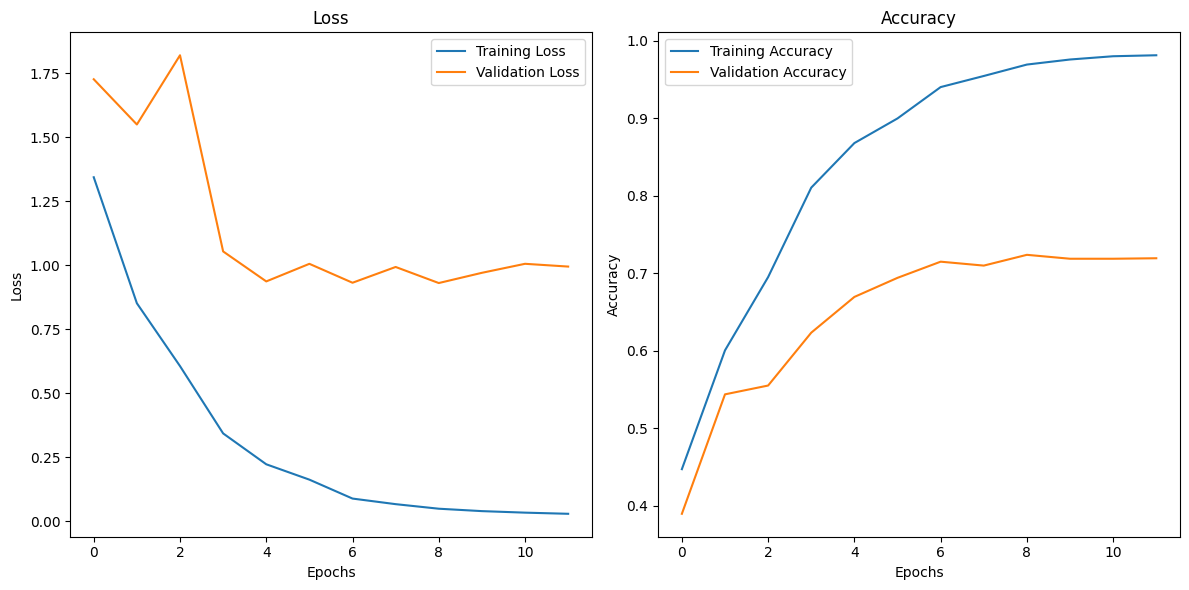

In [19]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
y_test_predicted = best_model.predict([X_test, csv_test])
y_test_predicted = [float(el.argmax()) for el in y_test_predicted]

test_loss, test_accuracy = best_model.evaluate([X_test, csv_test], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n\n')

print(classification_report(y_test, y_test_predicted))

50/50 [==============================] - 71s 1s/step - loss: 0.8692 - accuracy: 0.7522
Test Loss: 0.8692095875740051
Test Accuracy: 0.752212405204773


              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79        89
         1.0       0.76      0.72      0.74       203
         2.0       0.61      0.66      0.63        90
         3.0       0.79      0.82      0.81       114
         4.0       0.83      0.85      0.84       691
         5.0       0.60      0.49      0.54       125
         6.0       0.67      0.66      0.67       158
         7.0       0.55      0.59      0.57       112

    accuracy                           0.75      1582
   macro avg       0.70      0.70      0.70      1582
weighted avg       0.75      0.75      0.75      1582



### Adding class weigths and forcing overfitting to reduce

In [25]:
custom_class_weights = {
    0: 1.0,  # Well-performing class
    1: 1.2,
    2: 1.4,  # Underperforming class
    3: 1.0,  # Well-performing class
    4: 0.8,  # Overperforming class
    5: 1.6,  # Underperforming class
    6: 1.3,
    7: 1.7   # Underperforming class
}

In [26]:
best_hp=tuner.get_best_hyperparameters()[0]
best_hp.values['dropout_1'] = 0.40
best_hp.values['dropout_2'] = 0.35
best_hp.values['dropout_3'] = 0.30
best_hp.values['dropout_4'] = 0.25
best_hp.values['dropout_5'] = 0.20
best_hp.values['dropout_6'] = 0.15
best_hp.values['dropout_7'] = 0.10

print(best_hp.values)
best_model= tuner.hypermodel.build(best_hp)

{'pretrained_model': 'VGG-16', 'num_trainable_layers': 5, 'num_csv_layers_total': 3, 'num_dense_layers_total': 4, 'learning_rate': 0.0001, 'optimizer': 'rmsprop', 'units_1': 844, 'dropout_1': 0.4, 'units_2': 604, 'dropout_2': 0.35, 'units_3': 364, 'dropout_3': 0.3, 'units_4': 664, 'dropout_4': 0.25, 'units_5': 964, 'dropout_5': 0.2, 'units_6': 544, 'dropout_6': 0.15, 'units_7': 304, 'dropout_7': 0.1, 'units_csv_1': 66, 'dropout_csv_1': 0.0, 'units_csv_2': 128, 'dropout_csv_2': 0.2, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0011'}


In [27]:
history = best_model.fit([X_train, csv_train], y_train, epochs=20, validation_data=([X_val, csv_val], y_val), callbacks=[stop_early, reduce_lr], class_weight=custom_class_weights ) # MUST BE 100
best_model.summary()

Epoch 1/20
149/149 [==============================] - 325s 2s/step - loss: 1.7262 - accuracy: 0.4712 - val_loss: 1.4791 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 2/20
149/149 [==============================] - 308s 2s/step - loss: 1.2710 - accuracy: 0.5846 - val_loss: 1.2694 - val_accuracy: 0.5354 - lr: 1.0000e-04
Epoch 3/20
149/149 [==============================] - 316s 2s/step - loss: 1.0341 - accuracy: 0.6552 - val_loss: 1.2715 - val_accuracy: 0.5992 - lr: 1.0000e-04
Epoch 4/20
149/149 [==============================] - 327s 2s/step - loss: 0.7714 - accuracy: 0.7359 - val_loss: 0.7962 - val_accuracy: 0.6852 - lr: 5.0000e-05
Epoch 5/20
149/149 [==============================] - 358s 2s/step - loss: 0.6153 - accuracy: 0.7836 - val_loss: 0.9136 - val_accuracy: 0.6827 - lr: 5.0000e-05
Epoch 6/20
149/149 [==============================] - 374s 3s/step - loss: 0.4539 - accuracy: 0.8428 - val_loss: 0.8354 - val_accuracy: 0.6732 - lr: 2.5000e-05
Epoch 7/20
149/149 [====================

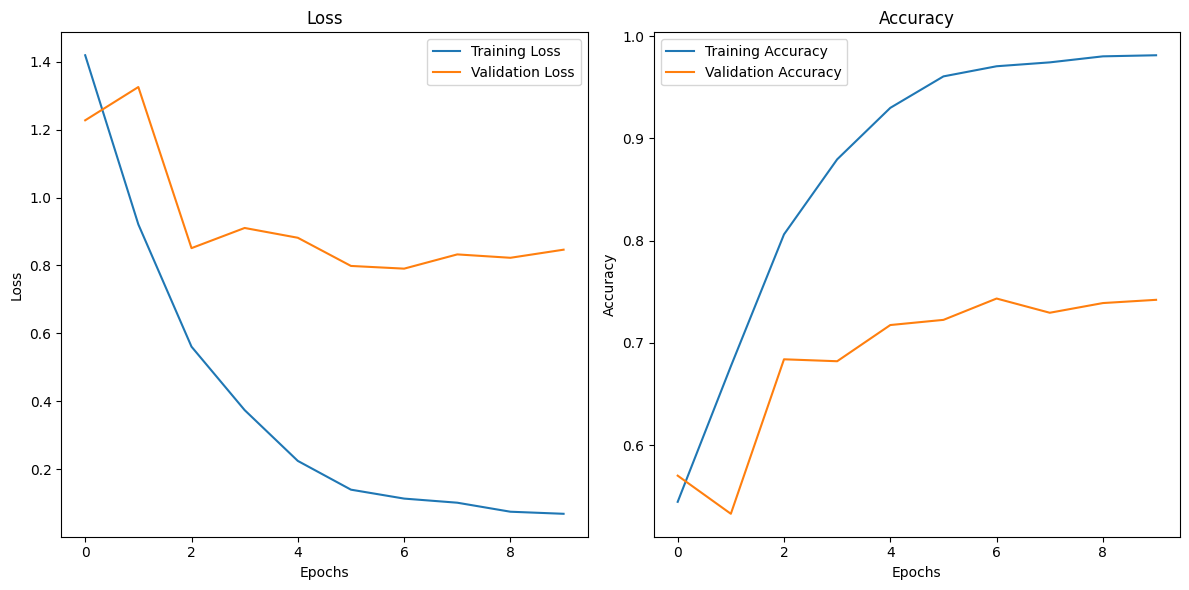

In [23]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
y_test_predicted = best_model.predict([X_test, csv_test])
y_test_predicted = [float(el.argmax()) for el in y_test_predicted]

test_loss, test_accuracy = best_model.evaluate([X_test, csv_test], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n\n')

print(classification_report(y_test, y_test_predicted))

50/50 [==============================] - 68s 1s/step - loss: 0.7546 - accuracy: 0.7497
Test Loss: 0.7545820474624634
Test Accuracy: 0.7496839165687561


              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76        89
         1.0       0.75      0.74      0.75       203
         2.0       0.67      0.54      0.60        90
         3.0       0.79      0.83      0.81       114
         4.0       0.82      0.86      0.84       691
         5.0       0.58      0.49      0.53       125
         6.0       0.65      0.72      0.68       158
         7.0       0.64      0.44      0.52       112

    accuracy                           0.75      1582
   macro avg       0.70      0.68      0.69      1582
weighted avg       0.74      0.75      0.74      1582

